# Particle Differential Energy Fluxes
author: Louis Richard\
Load brst particle distributions and convert to differential energy fluxes. Plots electron and ion fluxes and electron anisotropies.

In [1]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt

from pyrfu import mms, pyrf
from pyrfu.plot import plot_line, plot_spectr, make_labels
from scipy import constants

Load IGRF coefficients ...


## Define data path, spacecraft index and time interval

In [ ]:
mms.db_init(default="local", local="/data/mms")
ic = 3  # Spacecraft number
tint = ["2015-10-30T05:15:20.000", "2015-10-30T05:16:20.000"]

## Load data

### Particle distributions

In [3]:
vdf_i, vdf_e = [mms.get_data(f"pd{s}_fpi_brst_l2", tint, ic) for s in ["i", "e"]]

[08-Jun-23 18:27:47] INFO: Loading mms3_dis_dist_brst...
[08-Jun-23 18:27:47] WARNING: /usr/local/lib/python3.10/site-packages/pyrfu/mms/get_dist.py:68: UserWarning: Epoch_plus_var/Epoch_minus_var units are not clear, assume s
  warnings.warn(message)

[08-Jun-23 18:27:49] INFO: Loading mms3_des_dist_brst...


### Particle moments

In [4]:
n_i, n_e = [mms.get_data(f"n{s}_fpi_brst_l2", tint, ic) for s in ["i", "e"]]
v_xyz_i, v_xyz_e = [mms.get_data(f"v{s}_gse_fpi_brst_l2", tint, ic) for s in ["i", "e"]]
t_xyz_i, t_xyz_e = [mms.get_data(f"t{s}_gse_fpi_brst_l2", tint, ic) for s in ["i", "e"]]

[08-Jun-23 18:27:57] INFO: Loading mms3_dis_numberdensity_brst...
[08-Jun-23 18:27:57] WARNING: /usr/local/lib/python3.10/site-packages/pyrfu/mms/get_ts.py:58: UserWarning: Epoch_plus_var/Epoch_minus_var units are not clear, assume s
  warnings.warn(message)

[08-Jun-23 18:27:57] INFO: Loading mms3_des_numberdensity_brst...
[08-Jun-23 18:27:57] INFO: Loading mms3_dis_bulkv_gse_brst...
[08-Jun-23 18:27:57] INFO: Loading mms3_des_bulkv_gse_brst...
[08-Jun-23 18:27:57] WARNING: /usr/local/lib/python3.10/site-packages/pyrfu/mms/get_ts.py:58: UserWarning: Epoch_plus_var/Epoch_minus_var units are not clear, assume s
  warnings.warn(message)

[08-Jun-23 18:27:57] INFO: Loading mms3_dis_temptensor_gse_brst...
[08-Jun-23 18:27:57] WARNING: /usr/local/lib/python3.10/site-packages/pyrfu/mms/get_ts.py:58: UserWarning: Epoch_plus_var/Epoch_minus_var units are not clear, assume s
  warnings.warn(message)

[08-Jun-23 18:27:57] INFO: Loading mms3_des_temptensor_gse_brst...
[08-Jun-23 18:27:57] WARNING

### Other variables

In [5]:
b_xyz, b_gse = [mms.get_data(f"b_{cs}_fgm_brst_l2", tint, ic) for cs in ["dmpa", "gse"]]
e_xyz = mms.get_data("e_gse_edp_brst_l2", tint, ic)
scpot = mms.get_data("v_edp_brst_l2", tint, ic)
scpot = pyrf.resample(scpot, n_e)

[08-Jun-23 18:27:57] INFO: Loading mms3_fgm_b_dmpa_brst_l2...
[08-Jun-23 18:27:57] INFO: Loading mms3_fgm_b_gse_brst_l2...
[08-Jun-23 18:27:57] INFO: Loading mms3_edp_dce_gse_brst_l2...
[08-Jun-23 18:27:58] INFO: Loading mms3_edp_scpot_brst_l2...
[08-Jun-23 18:27:58] INFO: Using averages in resample


## Compute moments 

In [6]:
v_av = (
    0.5
    * constants.proton_mass
    * (1e3 * pyrf.norm(v_xyz_i)) ** 2
    / constants.electron_volt
)

### Compute parallel and perpendicular electron and ion temperatures

In [7]:
t_fac_i, t_fac_e = [
    mms.rotate_tensor(t_xyz, "fac", b_xyz, "pp") for t_xyz in [t_xyz_i, t_xyz_e]
]

t_para_i, t_para_e = [t_fac[:, 0, 0] for t_fac in [t_fac_i, t_fac_e]]
t_perp_i, t_perp_e = [t_fac[:, 1, 1] for t_fac in [t_fac_i, t_fac_e]]

[08-Jun-23 18:27:58] INFO: Using averages in resample
[08-Jun-23 18:27:58] INFO: Using averages in resample


### Compute Differential Energy Fluxes

In [8]:
def_omni_i, def_omni_e = [mms.vdf_omni(mms.psd2def(vdf)) for vdf in [vdf_i, vdf_e]]

### Compute Pitch-Angle Distribution

In [9]:
def_pad_e = mms.psd2def(mms.get_pitch_angle_dist(vdf_e, b_xyz, tint, angles=13))

[08-Jun-23 18:28:00] INFO: User defined number of pitch angles.
[08-Jun-23 18:28:00] INFO: Using averages in resample


### Compute parallel/anti-parallel and parallel+anti-parallel/perpandicular

In [10]:
def calc_parapar_parperp(pad):
    coords = [pad.time.data, pad.energy.data[0, :]]
    dims = ["time", "energy"]

    psd_parapar = def_pad_e.data.data[:, :, 0] / def_pad_e.data.data[:, :, -1]
    psd_parperp = (def_pad_e.data.data[:, :, 0] + def_pad_e.data.data[:, :, -1]) / (
        2 * def_pad_e.data.data[:, :, 7]
    )

    psd_parapar = xr.DataArray(psd_parapar, coords=coords, dims=dims)
    psd_parperp = xr.DataArray(psd_parperp, coords=coords, dims=dims)

    return psd_parapar, psd_parperp


vdf_parapar_e, vdf_parperp_e = calc_parapar_parperp(def_pad_e)

[08-Jun-23 18:28:09] WARNING: /var/folders/2t/0_80h219537d9f7j3ytlqtgh0000gn/T/ipykernel_34368/3690123158.py:5: RuntimeWarning: divide by zero encountered in divide
  psd_parapar = def_pad_e.data.data[:, :, 0] / def_pad_e.data.data[:, :, -1]

[08-Jun-23 18:28:09] WARNING: /var/folders/2t/0_80h219537d9f7j3ytlqtgh0000gn/T/ipykernel_34368/3690123158.py:5: RuntimeWarning: invalid value encountered in divide
  psd_parapar = def_pad_e.data.data[:, :, 0] / def_pad_e.data.data[:, :, -1]

[08-Jun-23 18:28:09] WARNING: /var/folders/2t/0_80h219537d9f7j3ytlqtgh0000gn/T/ipykernel_34368/3690123158.py:6: RuntimeWarning: divide by zero encountered in divide
  psd_parperp = (def_pad_e.data.data[:, :, 0] + def_pad_e.data.data[:, :, -1]) / (

[08-Jun-23 18:28:09] WARNING: /var/folders/2t/0_80h219537d9f7j3ytlqtgh0000gn/T/ipykernel_34368/3690123158.py:6: RuntimeWarning: invalid value encountered in divide
  psd_parperp = (def_pad_e.data.data[:, :, 0] + def_pad_e.data.data[:, :, -1]) / (



## Plot

In [11]:
legend_options = dict(
    frameon=False, loc="upper left", ncol=1, bbox_to_anchor=(1.0, 1.0)
)
e_lim_i = [min(def_omni_i.energy.data), max(def_omni_i.energy.data)]
e_lim_e = [min(def_omni_e.energy.data), max(def_omni_e.energy.data)]

[08-Jun-23 18:28:10] INFO: Substituting symbol \perp from STIXGeneral
[08-Jun-23 18:28:10] INFO: Substituting symbol \perp from STIXGeneral
[08-Jun-23 18:28:12] INFO: Substituting symbol \perp from STIXGeneral
[08-Jun-23 18:28:12] INFO: Substituting symbol \perp from STIXGeneral
[08-Jun-23 18:28:14] INFO: Substituting symbol \perp from STIXGeneral
[08-Jun-23 18:28:14] INFO: Substituting symbol \perp from STIXGeneral
[08-Jun-23 18:28:14] INFO: Substituting symbol \perp from STIXGeneral
[08-Jun-23 18:28:14] INFO: Substituting symbol \perp from STIXGeneral


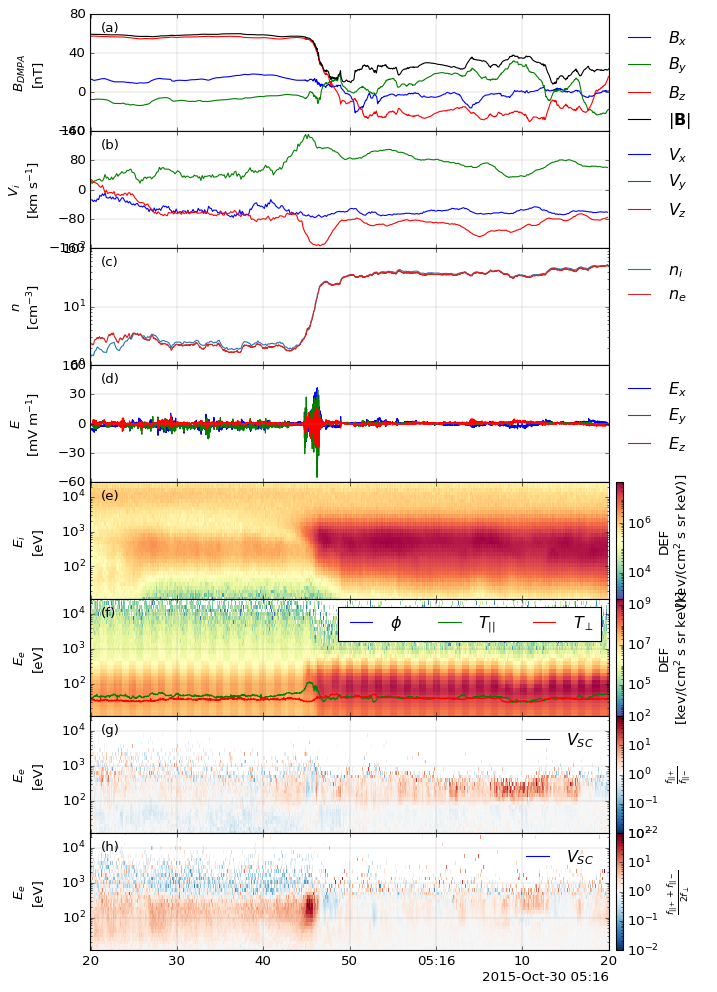

In [12]:
f, axs = plt.subplots(8, sharex="all", figsize=(9, 13))
f.subplots_adjust(hspace=0, left=0.1, right=0.82, bottom=0.05, top=0.95)

plot_line(axs[0], b_xyz)
plot_line(axs[0], pyrf.norm(b_xyz), color="k")
axs[0].set_ylabel("$B_{DMPA}$" + "\n" + "[nT]")
axs[0].legend(["$B_{x}$", "$B_{y}$", "$B_{z}$", "$|\\mathbf{B}|$"], **legend_options)

plot_line(axs[1], v_xyz_i)
axs[1].set_ylabel("$V_{i}$" + "\n" + "[km s$^{-1}$]")
axs[1].legend(["$V_{x}$", "$V_{y}$", "$V_{z}$"], **legend_options)

plot_line(axs[2], n_i, color="tab:blue")
plot_line(axs[2], n_e, color="tab:red")
axs[2].set_yscale("log")
axs[2].set_ylabel("$n$" + "\n" + "[cm$^{-3}$]")
axs[2].legend(["$n_i$", "$n_e$"], **legend_options)

plot_line(axs[3], e_xyz)
axs[3].set_ylabel("$E$" + "\n" + "[mV m$^{-1}$]")
axs[3].legend(["$E_{x}$", "$E_{y}$", "$E_{z}$"], **legend_options)


axs[4], caxs4 = plot_spectr(
    axs[4], def_omni_i, yscale="log", cscale="log", cmap="Spectral_r"
)
axs[4].set_ylabel("$E_i$" + "\n" + "[eV]")
caxs4.set_ylabel("DEF" + "\n" + "[kev/(cm$^2$ s sr keV)]")
axs[4].set_ylim(e_lim_i)

axs[5], caxs5 = plot_spectr(
    axs[5], def_omni_e, yscale="log", cscale="log", cmap="Spectral_r"
)
plot_line(axs[5], scpot)
plot_line(axs[5], t_para_e)
plot_line(axs[5], t_perp_e)
axs[5].set_ylabel("$E_e$" + "\n" + "[eV]")
caxs5.set_ylabel("DEF" + "\n" + "[kev/(cm$^2$ s sr keV)]")
axs[5].legend(["$\phi$", "$T_{||}$", "$T_{\perp}$"], ncols=3)
axs[5].set_yscale("log")
axs[5].set_ylim(e_lim_e)

axs[6], caxs6 = plot_spectr(
    axs[6], vdf_parapar_e, yscale="log", cscale="log", clim=[1e-2, 1e2], cmap="RdBu_r"
)
plot_line(axs[6], scpot)
axs[6].set_ylabel("$E_e$" + "\n" + "[eV]")
caxs6.set_ylabel("$\\frac{f_{||+}}{f_{||-}}$" + "\n" + " ")
axs[6].legend(["$V_{SC}$"], frameon=False)
axs[6].set_yscale("log")
axs[6].set_ylim(e_lim_e)

axs[7], caxs7 = plot_spectr(
    axs[7], vdf_parperp_e, yscale="log", cscale="log", clim=[1e-2, 1e2], cmap="RdBu_r"
)
plot_line(axs[7], scpot)
axs[7].set_ylabel("$E_e$" + "\n" + "[eV]")
caxs7.set_ylabel("$\\frac{f_{||+}+f_{||-}}{2 f_{\perp}}$" + "\n" + " ")
axs[7].legend(["$V_{SC}$"], frameon=False)
axs[7].set_yscale("log")
axs[7].set_ylim(e_lim_e)

make_labels(axs, [0.02, 0.85])

f.align_ylabels(axs)